# Import Dependencies

In [1]:
!pip3 install tensorflow-macos==2.9.0
!pip3 install tensorflow-metal==0.5.0

  Using cached tensorflow_macos-2.9.0-cp39-cp39-macosx_11_0_arm64.whl.metadata (2.9 kB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl.metadata (872 bytes)
  Using cached gast-0.4.0-py3-none-any.whl.metadata (1.1 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl.metadata (1.9 kB)
  Using cached tensorboard-2.9.1-py3-none-any.whl.metadata (1.9 kB)
  Using cached tensorflow_estimator-2.9.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached keras-2.9.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl.metadata (2.7 kB)
  Using cached protobuf-3.19.6-py2.py3-none-any.whl.metadata (828 bytes)
  Using cached tensorboard_data_server-0.6.1-py3-none-any.whl.metadata (1.1 kB)
  Using cached tensorboard_plugin_wit-1.8.1-py3-none-any.whl.metadata (873 bytes)
Using cached tensorflow_macos-2.9.0-cp39-cp39-macosx_11_0_arm64.whl (200.6 MB)
Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
Using cached gast-0.4.0-py3-

In [2]:
# reinstall all packages
# !pip install -r requirements.txt


In [3]:

from sklearn.metrics import mean_squared_error
import pickle 
from datetime import datetime
import matplotlib.pyplot as plt


In [4]:
from influxdb import DataFrameClient
import pandas as pd
db_name_zuka = 'smart_home_zukalovi'
dataframe_client_zuka = DataFrameClient(
            host='localhost',
            port=8086,
            username='root',
            password='root',
            database='smart_home_zukalovi',
        )

left_time_interval = pd.to_datetime('2023-10-01 00:00:00')
right_time_interval = pd.to_datetime('2024-04-22 15:00:00')
left_time_interval = f"'{left_time_interval.strftime('%Y-%m-%dT%H:%M:%SZ')}'"
right_time_interval = f"'{right_time_interval.strftime('%Y-%m-%dT%H:%M:%SZ')}'"
group_by_time_interval = '10s'
tmp_output_water_entity_id_zuka = 'esphome_web_c771e8_ntc_temperature_b_constant'
tmp_output_water_entity_id_2_zuka = 'esphome_web_c771e8_ntc_temperature_b_constant_2'
tmp_boiler_case_entity_id_zuka = 'esphome_web_c771e8_tmp3'
relay_entity_id_zuka = 'shelly1pm_84cca8b07eae'
device_tracker_entity_zuka = 'klara_z_iphone'


/Users/adamgrunwald/Desktop/FIT/smartboiler/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [5]:
dataframe_client_form = DataFrameClient(
            host='localhost',
            port=8086,
            username='root',
            password='root',
            database='smart_home_formankovi',
        )
db_name_form = 'smart_home_formankovi'
tmp_output_water_entity_id_form = 'esphome_boiler_temps_ntc_temperature_b_constant'
tmp_output_water_entity_id_2_form = 'esphome_web_b7a7f1_ntc_temperature_b_constant'
tmp_boiler_case_entity_id_form = 'shelly1pm_34945475a969_temperature_2'
relay_entity_id_form = 'shelly1pm_34945475a969'
device_tracker_entity_form = 'rmx3085'

In [6]:

# format datetime to YYYY-MM-DDTHH:MM:SSZ


def get_queries(db_name, left_time_interval, right_time_interval, group_by_time_interval, tmp_output_water_entity_id, tmp_output_water_entity_id_2, tmp_boiler_case_entity_id, relay_entity_id, device_tracker_entity):

    return {
        "water_flow": {
            "sql_query": f'SELECT mean("value") AS "water_flow_L_per_minute_mean" FROM "{db_name}"."autogen"."L/min" WHERE time > {left_time_interval} AND time < {right_time_interval} GROUP BY time({group_by_time_interval}) FILL(0)',
            "measurement": "L/min",
        },
        "water_temperature": {
            "sql_query": f'SELECT mean("value") AS "water_temperature_mean" FROM "{db_name}"."autogen"."°C" WHERE time > {left_time_interval} AND time < {right_time_interval} AND ("entity_id"=\'{tmp_output_water_entity_id}\' OR "entity_id"=\'{tmp_output_water_entity_id_2}\') GROUP BY time({group_by_time_interval}) FILL(0)',
            "measurement": "°C",
        },
        "temperature": {
            "sql_query": f'SELECT mean("temperature") AS "outside_temperature_mean" FROM "{db_name}"."autogen"."state" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "domain"=\'weather\' AND "entity_id"=\'domov\' GROUP BY time({group_by_time_interval}) FILL(null)',
            "measurement": "state",
        },
        "humidity": {
            "sql_query": f'SELECT mean("humidity") AS "outside_humidity_mean" FROM "{db_name}"."autogen"."state" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "domain"=\'weather\' AND "entity_id"=\'domov\' GROUP BY time({group_by_time_interval}) FILL(null)',
            "measurement": "state",
        },
        "wind_speed": {
            "sql_query": f'SELECT mean("wind_speed") AS "outside_wind_speed_mean" FROM "{db_name}"."autogen"."state" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "entity_id"=\'domov\' GROUP BY time({group_by_time_interval}) FILL(null)',
            "measurement": "state",
        },
        "presence": {
            "sql_query": f'SELECT count(distinct("friendly_name_str")) AS "device_presence_distinct_count" FROM "{db_name}"."autogen"."state" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "domain"=\'device_tracker\' AND "state"=\'home\' GROUP BY time({group_by_time_interval}) FILL(0)',
            "measurement": "state",
        },
        "boiler_water_temperature": {
            "sql_query": f'SELECT mean("value") AS "boiler_water_temperature_mean" FROM "{db_name}"."autogen"."°C" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "entity_id"=\'{tmp_boiler_case_entity_id}\' GROUP BY time({group_by_time_interval}) FILL(null)',
            "measurement": "°C",
        },
        "boiler_relay_status": {
            "sql_query": f'SELECT last("value") AS "boiler_relay_status" FROM "{db_name}"."autogen"."state" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "entity_id"=\'{relay_entity_id}\' GROUP BY time({group_by_time_interval}) FILL(null)',
            "measurement": "state",
        },
        "device_longitude": {
            "sql_query": f'SELECT mean("longitude") AS "mean_longitude" FROM "{db_name}"."autogen"."state" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "domain"=\'device_tracker\' AND "entity_id"=\'{device_tracker_entity}\' GROUP BY time({group_by_time_interval}) FILL(previous)',
            "measurement": "state",
        },
        "device_latitude": {
            "sql_query": f'SELECT mean("latitude") AS "mean_latitude" FROM "{db_name}"."autogen"."state" WHERE time > {left_time_interval} AND time < {right_time_interval} AND "domain"=\'device_tracker\' AND "entity_id"=\'{device_tracker_entity}\' GROUP BY time({group_by_time_interval}) FILL(previous)',
            "measurement": "state",
        },
        
    } 

In [7]:
# df_all_list = []

# for key, value in get_queries(db_name = db_name_form, left_time_interval = left_time_interval, right_time_interval = right_time_interval, group_by_time_interval = group_by_time_interval, tmp_output_water_entity_id = tmp_output_water_entity_id_form, tmp_output_water_entity_id_2 = tmp_output_water_entity_id_2_form, tmp_boiler_case_entity_id = tmp_boiler_case_entity_id_form, relay_entity_id = relay_entity_id_form, device_tracker_entity = device_tracker_entity_form).items():
#     print("Querying: ", key, value["sql_query"])
#     # get data from influxdb
#     result = dataframe_client_form.query(value["sql_query"])[
#         value["measurement"]
#     ]

#     df = pd.DataFrame(result)
    
#     df_all_list.append(df)

# df_concat_form = pd.concat(df_all_list, axis=1)
# # save as pkl
# with open('src/smartboiler/pkl/df_form_mult_22042024.pkl', 'wb') as f:
#     df_concat_form.to_pickle(f)

In [8]:
# df_all_list = []
#     # iterate over key an value in data
# for key, value in get_queries(db_name=db_name_zuka, left_time_interval=left_time_interval, right_time_interval=right_time_interval, group_by_time_interval='10s', tmp_output_water_entity_id=tmp_output_water_entity_id_2_zuka, tmp_output_water_entity_id_2=tmp_output_water_entity_id_zuka, tmp_boiler_case_entity_id=tmp_boiler_case_entity_id_zuka, relay_entity_id=relay_entity_id_zuka, device_tracker_entity=device_tracker_entity_zuka).items():
#     print("Querying: ", key, value["sql_query"])
#     # get data from influxdb
#     result = dataframe_client_zuka.query(value["sql_query"])[
#         value["measurement"]
#     ]

#     df = pd.DataFrame(result)
    
#     df_all_list.append(df)

# df_concat_zuka = pd.concat(df_all_list, axis=1)
# # save as pkl
# with open('src/smartboiler/pkl/df_zuka_mult_22042024.pkl', 'wb') as f:
#     df_concat_zuka.to_pickle(f)

In [9]:
# #load df form pkl
# with open('src/smartboiler/pkl/df_form_mult_22042024.pkl', 'rb') as f:
#     df_concat_form = pickle.load(f)
#     df_concat_form = df_concat_form.dropna(subset=['water_temperature_mean'])

    
    


In [10]:
# with open('src/smartboiler/pkl/df_zuka_mult_22042024.pkl', 'rb') as f:
#     df_concat_zuka = pickle.load(f)
#     df_concat_zuka = df_concat_zuka.dropna(subset=['water_temperature_mean'])
    


In [11]:
from src.smartboiler.data_handler import DataHandler

Importing /Users/adamgrunwald/Desktop/FIT/smartboiler/smartboiler/src/smartboiler/__init__.py


In [12]:
left_time_interval = pd.to_datetime("2023-10-01 00:00:00")
right_time_interval = pd.to_datetime("2024-6-6 15:00:00")
left_time_interval = f"'{left_time_interval.strftime('%Y-%m-%dT%H:%M:%SZ')}'"
right_time_interval = f"'{right_time_interval.strftime('%Y-%m-%dT%H:%M:%SZ')}'"
group_by_time_interval = "10s"
tmp_output_water_entity_id_zuka = "esphome_web_c771e8_ntc_temperature_b_constant"
tmp_output_water_entity_id_2_zuka = "esphome_web_c771e8_ntc_temperature_b_constant_2"
tmp_boiler_case_entity_id_zuka = "esphome_web_c771e8_tmp3"
relay_entity_id_zuka = "shelly1pm_84cca8b07eae"
relay_power_entity_id_zuka = "shelly1pm_84cca8b07eae_power"
device_tracker_entity_zuka = "klara_z_iphone"
device_tracker_entity_zuka_2 = "anezka_iphone"
zuka_home_longitude = 16.514843458109933
zuka_home_latitude = 49.412897925874184 
dataHandlerZuka = DataHandler(
    "localhost", "smart_home_zukalovi", "root", "root", relay_entity_id_zuka, tmp_boiler_case_entity_id_zuka, tmp_output_water_entity_id_zuka, tmp_output_water_entity_id_2_zuka, device_tracker_entity_zuka,device_tracker_entity_zuka_2, zuka_home_longitude, zuka_home_latitude
)

In [13]:

# data_processed_zuka = dataHandlerZuka.process_kWh_water_consumption(df_extracted_zuka)
# data_processed_zuka_ml = dataHandlerZuka.transform_data_for_ml(data_processed_zuka)
# ml_data_zuka = data_processed_zuka_ml[0]
import os
path = 'src/smartboiler/pkl/ml_data_zuka_18.pkl'
if (os.path.exists(path)):
    with open(path, 'rb') as f:
        ml_data_zuka = pickle.load(f)
else:
    ml_data_zuka = dataHandlerZuka.get_data_for_prediction(datetime(2023, 10, 1, 0, 0, 0), datetime(2024, 6, 6, 0, 0, 0))
    # save as pkl to src/smartboiler/pkl
    with open(path, 'wb') as f:
        pickle.dump(ml_data_zuka, f)


In [14]:
db_name_form = 'smart_home_formankovi'
tmp_output_water_entity_id_form = 'esphome_boiler_temps_ntc_temperature_b_constant'
tmp_output_water_entity_id_2_form = 'esphome_web_b7a7f1_ntc_temperature_b_constant'
tmp_boiler_case_entity_id_form = 'shelly1pm_34945475a969_temperature_2'
relay_entity_id_form = 'shelly1pm_34945475a969'
device_tracker_entity_form = 'rmx3085'
device_tracker_entity_form_2 = 'rmx3085'
form_home_longitude = 16.514843458109933
form_home_latitude = 49.412897925874184

dataHandlerForm = DataHandler(
    "localhost", db_name_form, "root", "root", relay_entity_id_form, tmp_boiler_case_entity_id_form, tmp_output_water_entity_id_form, tmp_output_water_entity_id_2_form, device_tracker_entity_form, device_tracker_entity_form_2, form_home_longitude, form_home_latitude
)

In [15]:
# data_processed_form = dataHandlerForm.process_kWh_water_consumption(df_extracted_form)
# data_processed_form_ml = dataHandlerForm.transform_data_for_ml(data_processed_form)
# ml_data_form = data_processed_form_ml[0]
path = 'src/smartboiler/pkl/ml_data_form_18.pkl'
if (os.path.exists(path)):    
    with open(path, 'rb') as f:
        ml_data_form = pickle.load(f)
else:
    ml_data_form= dataHandlerForm.get_data_for_prediction(datetime(2023, 10, 1, 0, 0, 0), datetime(2024, 6, 6, 0, 0, 0))
    with open(path, 'wb') as f:
        pickle.dump(ml_data_form, f)


In [16]:
ml_data_form_datetimes = ml_data_form.copy().reset_index(drop=True)

ml_data_zuka_datetimes = ml_data_zuka.copy().reset_index(drop=True)



# replace nan humidity, temeprature and wind_speed with values with same index from ml_data_zuka
ml_data_form_datetimes['temperature'] = ml_data_form_datetimes['temperature'].combine_first(ml_data_zuka_datetimes['temperature'])
ml_data_form_datetimes['humidity'] = ml_data_form_datetimes['humidity'].combine_first(ml_data_zuka_datetimes['humidity'])
ml_data_form_datetimes['wind_speed'] = ml_data_form_datetimes['wind_speed'].combine_first(ml_data_zuka_datetimes['wind_speed'])

# ffill this values
ml_data_form_datetimes['temperature'] = ml_data_form_datetimes['temperature'].ffill()
ml_data_form_datetimes['humidity'] = ml_data_form_datetimes['humidity'].ffill()
ml_data_form_datetimes['wind_speed'] = ml_data_form_datetimes['wind_speed'].ffill()

ml_data_form = ml_data_form_datetimes.reset_index(drop=True)



In [17]:
import random

In [18]:
def shuffle_weeks(df):
    # randomly split data to train and test by 24 hours
    # shuffle data with keeping 24 hours together
    num_hours_per_week = 24 * 7
    num_complete_weeks = len(df) // num_hours_per_week
    # Truncate the dataframe to a multiple of a week
    df_truncated = df.iloc[:num_complete_weeks * num_hours_per_week]
    # Split the dataframe into weeks
    weeks = [df_truncated.iloc[i:i + num_hours_per_week] for i in range(0, len(df_truncated), num_hours_per_week)]
    random.shuffle(weeks)

    return pd.concat(weeks).reset_index(drop=True)

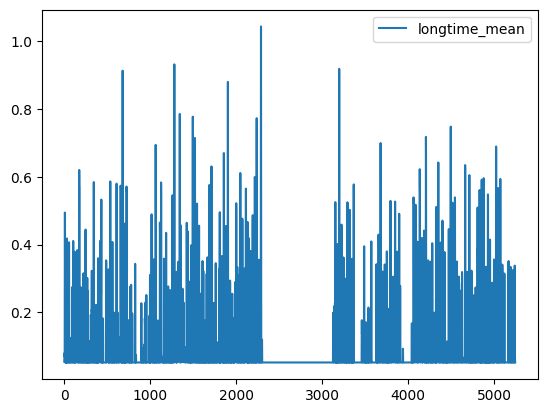

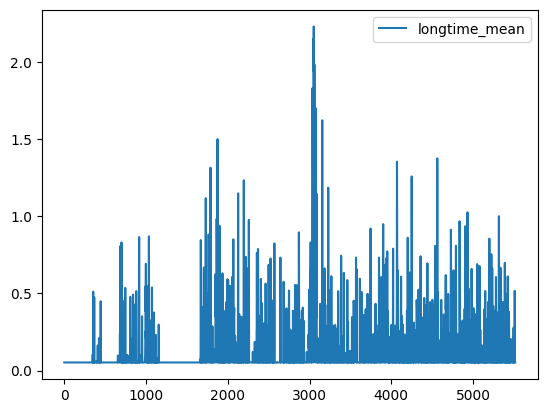

In [19]:
##FOR
df_form = ml_data_form.reset_index(drop=True).copy()
#60T
df_form.plot(y='longtime_mean')
df_60T_form = pd.concat([df_form.iloc[500:2300], df_form.iloc[3200:]])

with open('df_60T_form.pkl', 'wb') as f:
    df_60T_form.to_pickle(f)

#d
df_form = df_60T_form.reset_index(drop=True).copy()
df_form = df_form.dropna(subset=['last_3_week_skew'])
df_form['distance_from_home'] = df_form['distance_from_home'].apply(lambda x: x if x < 50 else 50)


df_form = shuffle_weeks(df_form)


df_train_form = df_form.loc[:int(df_form.shape[0]*0.8),:]
df_test_form = df_form.loc[int(df_form.shape[0]*0.8):,:]

# ## ZUKA

ml_data_zuka.plot(y='longtime_mean')
df_zuka = ml_data_zuka.iloc[1700:].reset_index(drop=True).copy()

#60T

df_60T_zuka = df_zuka
with open('df_60T_zuka.pkl', 'wb') as f:
    df_60T_zuka.to_pickle(f)

df_zuka = df_60T_zuka.reset_index(drop=True).copy()
df_zuka['distance_from_home_2'] = df_zuka['distance_from_home_2'].apply(lambda x: x if x < 30 else 30)
df_zuka['distance_from_home'] = df_zuka['distance_from_home'].apply(lambda x: x if x < 30 else 30)


# df_zuka = shuffle_weeks(df_zuka)
df_train_zuka = df_zuka.loc[:int(df_zuka.shape[0]*0.8),:]
df_test_zuka = df_zuka.loc[int(df_zuka.shape[0]*0.8):,:]


# df = df_60T.reset_index(drop=True).dropna()

df_train = pd.concat([df_train_form, df_train_zuka]).reset_index(drop=True).dropna()
df_test = pd.concat([df_test_form, df_test_zuka]).reset_index(drop=True).dropna()




In [20]:
df_60T_form.columns

Index(['longtime_mean', 'last_3_week_skew', 'last_3_week_std',
       'distance_from_home', 'speed_towards_home', 'distance_from_home_2',
       'speed_towards_home_2', 'count', 'heading_to_home_sin',
       'heading_to_home_cos', 'heading_to_home_sin_2', 'heading_to_home_cos_2',
       'temperature', 'humidity', 'wind_speed', 'weekday_sin', 'weekday_cos',
       'hour_sin', 'hour_cos'],
      dtype='object')

In [21]:
# from keras.models import Sequential
# from keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
# from keras.utils import plot_model
# model = Sequential()
# model.add(Input(shape=(None, 18)))
# model.add(LSTM(100))
# model.add(Dense(1))

# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

        

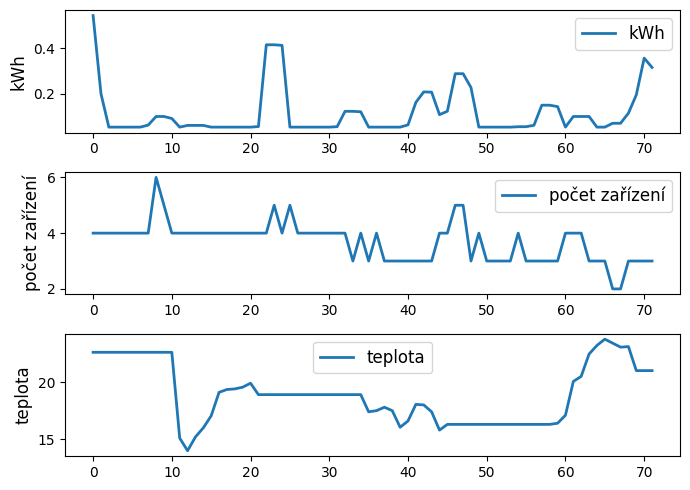

In [22]:
# show 24 stats of longtime mean, count, distnance from home, temperature in 3 separate figs
from turtle import width
from matplotlib import pyplot as plt
from pyparsing import line
fig, axs = plt.subplots(3, 1, figsize=(7, 5))
df_plot_24h = df_train_form.iloc[:24*3]
df_plot_24h.plot(y='longtime_mean', ax=axs[0],linewidth=2)
df_plot_24h.plot(y='count', ax=axs[1], linewidth=2)
df_plot_24h.plot(y='temperature', ax=axs[2], linewidth=2)

# rename the legend to kWh, pocet pripojenych zarizeni and teplota
axs[0].legend(['kWh'],fontsize=12)
axs[1].legend(['počet zařízení'],fontsize=12)
axs[2].legend(['teplota'],fontsize=12)
# make the letters bigger
axs[0].set_ylabel('kWh', fontsize=12)
axs[1].set_ylabel('počet zařízení', fontsize=12)
axs[2].set_ylabel('teplota', fontsize=12)
# tight layous
plt.tight_layout()

# save as pdf
plt.savefig('24h_stats.png', dpi=500)

<AxesSubplot:>

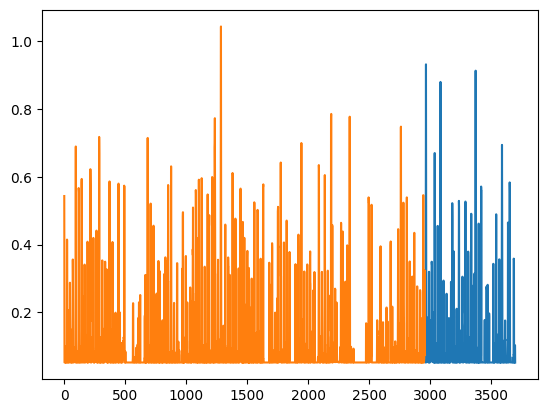

In [23]:
#plot df_form longtime_mean
df_test_form['longtime_mean'].plot()
df_train_form['longtime_mean'].plot()

## Normalize the Data
- for available scalers see: http://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py
- becareful of outliers when scaling!
- perform the normalization on the pandas dataframe

## Use a data generator
- creates batches on the fly
- good for data with large number of rows and features
- don't need to perform lags on dataframe
- the function below was adapted from https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.3-advanced-usage-of-recurrent-neural-networks.ipynb
- note: Keras added a TimeseriesGenerator class in version 2.1.5 
    - https://github.com/keras-team/keras/releases/tag/2.1.5
    - keras.preprocessing.sequence.TimeseriesGenerator
keras.preprocessing.sequence.TimeseriesGenerator
It yields a tuple `(samples, targets)` where `samples` is one batch of input data and 
`targets` is the corresponding array of target temperatures. It takes the following arguments:

* `dataframe`: pandas dataframe with feature matrix and target column
* `target_name`: string of column with target values
* `lookback`: How many timesteps back should our input data go.
* `delay`: How many timesteps in the future should our target be.
* `min_index` and `max_index`: Indices in the `data` array that delimit which timesteps to draw from. This is useful for keeping a segment 
of the data for validation and another one for testing.
* `shuffle`: Whether to shuffle our samples or draw them in chronological order.
* `batch_size`: The number of samples per batch.
* `step`: The period, in timesteps, at which we sample data. We will set it 6 in order to draw one data point every hour.

## create train, validation, test data generators
- we will 20% of the df_train to get the validation generator
    - use the min_index,max_index arguments for slices from generator function

In [24]:
from pytz import utc
import pandas as pd
import numpy as np
from src.smartboiler.forecast import Forecast
from src.smartboiler.data_handler import DataHandler
from datetime import datetime, timedelta



ModuleNotFoundError: No module named 'smartboiler'

In [ ]:
# get nan values in df_train_form
nan_values = df_train_form.isnull().sum()
print(nan_values)

longtime_mean            0
last_3_week_skew         0
last_3_week_std          0
distance_from_home       0
speed_towards_home       0
distance_from_home_2     0
speed_towards_home_2     0
count                    0
heading_to_home_sin      0
heading_to_home_cos      0
heading_to_home_sin_2    0
heading_to_home_cos_2    0
temperature              0
humidity                 0
wind_speed               0
weekday_sin              0
weekday_cos              0
hour_sin                 0
hour_cos                 0
dtype: int64


In [ ]:
def get_model(
    df_train,
    df_focused,
    dataHandler,
    predicted_columns,
    model_path,
    scaler_path,
    train_on_all,
    do_train,
    test_data
):

    # use previous 450 samples to predict next target ('pollution') samples

    start_of_data = datetime(2023, 11, 1, 0, 0, 0)
    forecast = Forecast(
        dataHandler,
        start_of_data=start_of_data,
        model_path=model_path,
        scaler_path=scaler_path,
        predicted_columns=predicted_columns,
    )
    forecast.build_model()

    if do_train:
        if train_on_all:
            forecast.train_model(df_training_data=df_train, begin_of_training=start_of_data)
        forecast.train_model(df_training_data=df_focused)

    forecast.load_model(

    )
    return forecast


predicted_columns = [
        "longtime_mean",
]
model_path_form = 'src/smartboiler/models/model_form_fold.weights.h5'
scaler_path_form = "src/smartboiler/pkl/scaler_form.pkl"

model_path_zuka = 'src/smartboiler/models/model_zuka.weights.h5'
scaler_path_zuka = "src/smartboiler/pkl/scaler_zuka.pkl"


# forecast = get_model(
#     df_train,
#     df_train_form,
#     dataHandlerForm,
#     predicted_columns,
#     model_path_form,
#     scaler_path_form,
#     train_on_all = False,
#     do_train=True,
#         test_data=df_test_zuka

# )


# df_test_norm = df_train_form.reset_index(drop=True).copy()
# df_test_direct = df_test_form


forecast = get_model(
    df_train,
    df_train_zuka,
    dataHandlerZuka,
    predicted_columns,
    model_path_zuka,
    scaler_path_zuka,
    train_on_all = False,
    do_train=True,
    test_data=df_test_zuka
)


# plot loss and val function



Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-06-15 20:20:13.012737: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-15 20:20:13.012872: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2024-06-15 20:20:13.312530: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-06-15 20:20:14.039121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-06-15 20:20:14.192029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-06-15 20:20:14.490542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-06-15 20:20:15.775166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-06-15 20:20:15.829887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.49570, saving model to src/smartboiler/models/model_zuka.weights.h5
21/21 - 3s - loss: 0.6308 - val_loss: 0.4957 - 3s/epoch - 129ms/step
Epoch 2/100

Epoch 2: val_loss did not improve from 0.49570
21/21 - 0s - loss: 0.6027 - val_loss: 0.5556 - 378ms/epoch - 18ms/step
Epoch 3/100

Epoch 3: val_loss improved from 0.49570 to 0.43237, saving model to src/smartboiler/models/model_zuka.weights.h5
21/21 - 0s - loss: 0.5422 - val_loss: 0.4324 - 421ms/epoch - 20ms/step
Epoch 4/100

Epoch 4: val_loss improved from 0.43237 to 0.30871, saving model to src/smartboiler/models/model_zuka.weights.h5
21/21 - 0s - loss: 0.4300 - val_loss: 0.3087 - 374ms/epoch - 18ms/step
Epoch 5/100

Epoch 5: val_loss did not improve from 0.30871
21/21 - 0s - loss: 0.4538 - val_loss: 0.3481 - 372ms/epoch - 18ms/step
Epoch 6/100

Epoch 6: val_loss did not improve from 0.30871
21/21 - 0s - loss: 0.4305 - val_loss: 0.4087 - 380ms/epoch - 18ms/step
Epoch 7/100

Epoch 7: val_loss did

In [ ]:
df_test_norm = df_train_zuka.reset_index(drop=True).copy()
df_test_direct = df_test_zuka

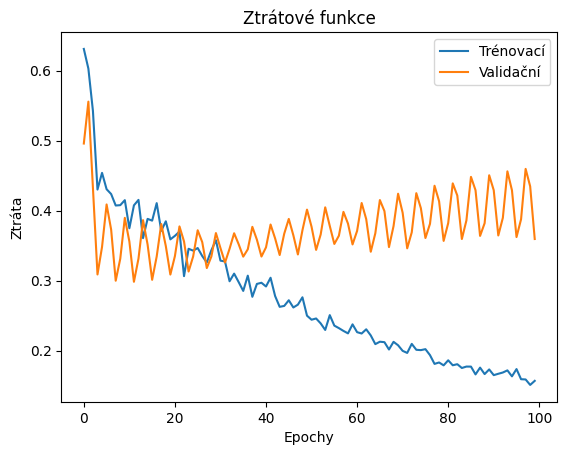

In [ ]:
# plot loss and val function
loss = forecast.history.history['loss']
val_loss = forecast.history.history['val_loss']

# Plot the loss values
plt.plot(loss, label='Trénovací')
plt.plot(val_loss, label='Validační')
plt.title('Ztrátové funkce')
plt.xlabel('Epochy')
plt.ylabel('Ztráta')
plt.legend()
# save as png dpi 500
plt.savefig('loss_function.png', dpi=500)
plt.show()

In [ ]:
!pip3 install tensorflow-metal==0.5.0




[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


(18, 400)
[0.06224925 0.06675842 0.06431628 0.0624712  0.06084718 0.06086709
 0.06498027 0.06188447 0.0606185  0.05994986 0.05871386 0.05836847
 0.06550606 0.05786199 0.06537504 0.06262287 0.06608237 0.06844436]


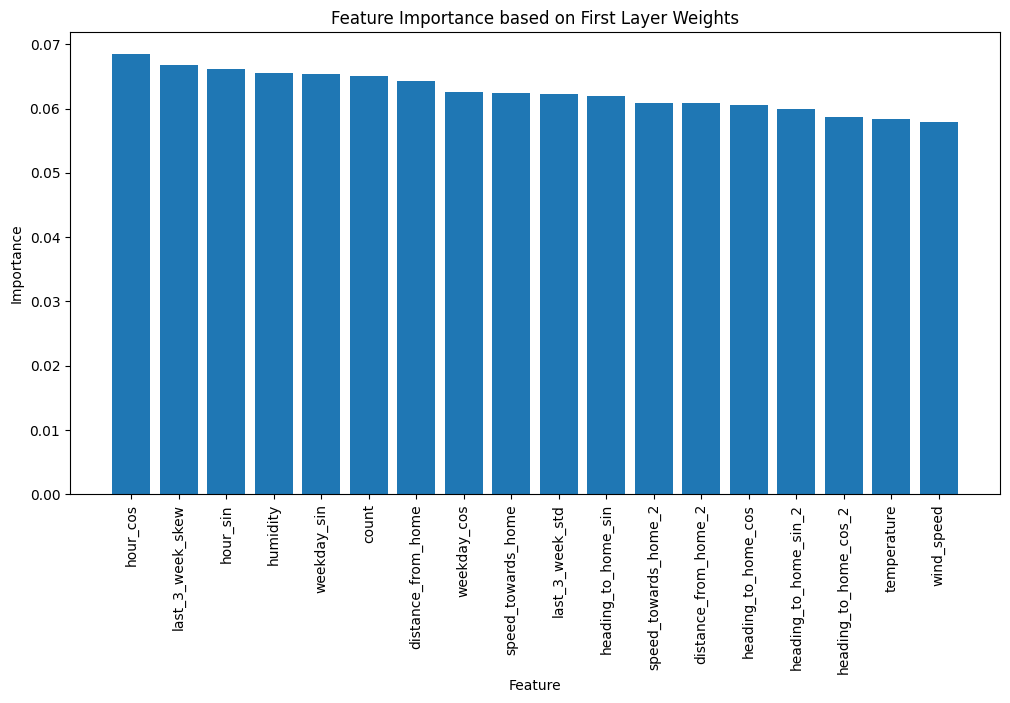

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your model is already trained and defined as `model`
# Get the weights of the first dense layer (or the first LSTM layer if using LSTM)
layer_weights = forecast.model.layers[0].get_weights()[0]
print(layer_weights.shape)
# Average absolute weights across neurons
average_weights = np.mean(np.abs(layer_weights), axis=1)
print(average_weights)
# Create a DataFrame for visualization
features =             [
                "last_3_week_std",
                "last_3_week_skew",
                "distance_from_home",
                "speed_towards_home",
                "distance_from_home_2",
                "speed_towards_home_2",
                "count",
                "heading_to_home_sin",
                "heading_to_home_cos",
                "heading_to_home_sin_2",
                "heading_to_home_cos_2",
                "temperature",
                "humidity",
                "wind_speed",
                "weekday_sin",
                "weekday_cos",
                "hour_sin",
                "hour_cos",
            ]
feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': average_weights
}).sort_values(by='importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 6))
plt.bar(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance based on First Layer Weights')
plt.show()

In [ ]:

left_test = datetime(2023,12,30)
right_test = datetime(2024,4,1)

from sklearn.metrics import mean_squared_error
from scipy import stats
import matplotlib.pyplot as plt

# df_test_direct, _ = forecast.dataHandler.get_data_for_prediction(left_test, right_test)

df_test_norm = df_test_direct.reset_index(drop=True).copy()

# df_test_norm = df_test_zuka.copy()
df_test_norm[df_test_norm.columns] = forecast.scaler.transform(df_test_norm)


In [ ]:
test_gen = forecast.mul_generator(dataframe = df_test_norm, 
                     target_names = predicted_columns, 
                     min_index = 0,
                     max_index = None,
                     shuffle = False,
                     batch_size = df_test_norm.shape[0])
(X, y_truth) = next(test_gen)
# X_reshaped = X.reshape((X.shape[0], 1, X.shape[1]))

y_pred = forecast.model.predict(X)

2024-06-15 20:20:53.717458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-06-15 20:20:53.770518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 1s 11ms/step


In [ ]:
!pip3 install eli5


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [ ]:
from pyparsing import col


feature_df = pd.DataFrame(columns=['feature','layer','neuron','weight','abs_weight'])
features =             [
                "last_3_week_skew",
                "last_3_week_std",
                "distance_from_home",
                "speed_towards_home",
                "distance_from_home_2",
                "speed_towards_home_2",
                "count",
                "heading_to_home_sin",
                "heading_to_home_cos",
                "heading_to_home_sin_2",
                "heading_to_home_cos_2",
                "temperature",
                "humidity",
                "wind_speed",
                "weekday_sin",
                "weekday_cos",
                "hour_sin",
                "hour_cos",
            ]
# features cesky
features =             [
                "šikmost spotřeby",
                "sm. odchylka spotřeby",
                "vzdálenost 1",
                "rychlost 1",
                "vzdálenost 2",
                "rychlost 2",
                "počet zařízení",
                "směr sin",
                "směr cos",
                "směr sin 2",
                "směr cos 2",
                "teplota",
                "vlhkost",
                "rychlost větru",
                "den v týdnu sin",
                "den v týdnu cos",
                "hodina sin",
                "hodina cos",
]

for i,layer in enumerate(forecast.model.layers[:-1]): 
    w = layer.get_weights()
    w = np.array(w[0])
    n = 0
    for neuron in w.T:
        for f,name in zip(neuron,features):
            feature_df.loc[len(feature_df)] = [name,i,n,f,abs(f)]
        
        n+=1
    break
        
feature_df = feature_df.sort_values(by=['abs_weight'])
feature_df.reset_index(inplace=True)
feature_df = feature_df.drop(['index'], axis=1)
# set axis size to 12, 4


# grouped_df = feature_df.groupby(['feature', 'neuron'])['weight'].sum().reset_index()
# # sort by weight
# grouped_df = grouped_df.sort_values(by='weight', ascending=False)
# # Plotting the bar chart

# # plot the data with feature on x axis and sum of absolute weights on y axis
# plt.figure(figsize=(12, 6))
# # each column different color
# plt.bar(grouped_df['feature'], grouped_df['weight'], color=np.random.rand(3,))


# # for neuron in grouped_df['neuron'].unique():
# #     feature_data = grouped_df[grouped_df['neuron'] == neuron]
# #     plt.bar(feature_data['feature'], feature_data['weight'], label=neuron, sorted=True, color=np.random.rand(3,)) 
# #     break
# plt.xlabel('Feature')
# plt.ylabel('Sum of absolute weights')
# plt.title('Sum of absolute weights for each feature in each neuron')
# plt.show()


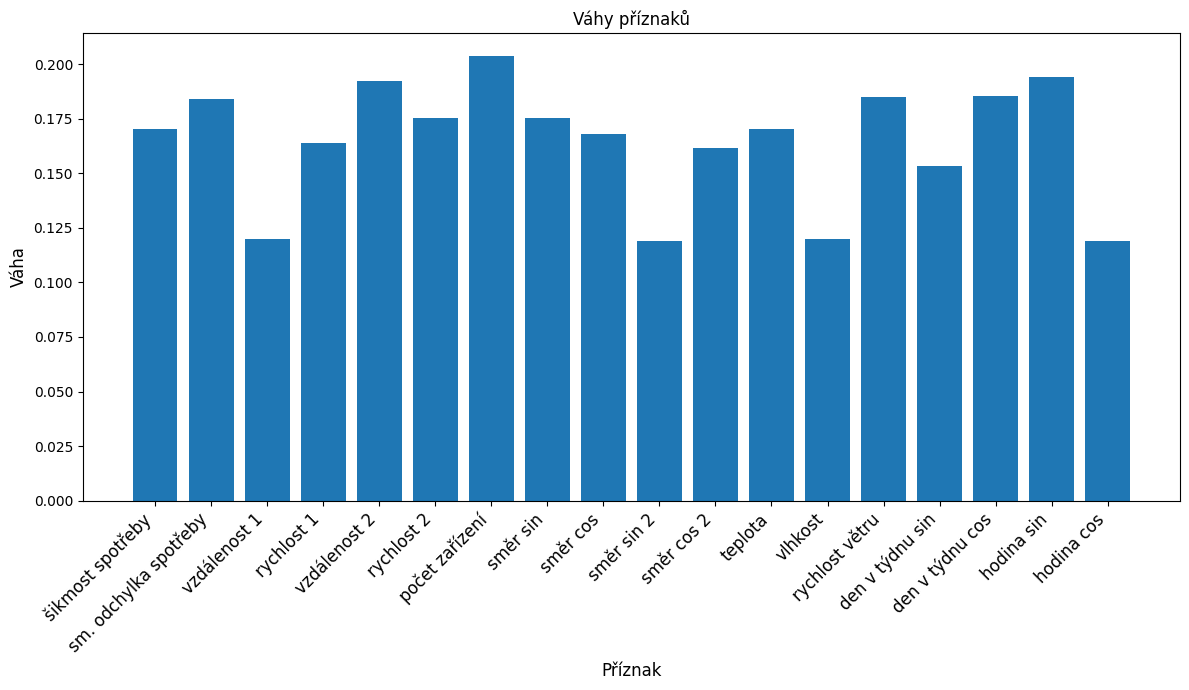

In [ ]:
plt.figure(figsize=(12, 7))
plt.bar(feature_df['feature'],feature_df['abs_weight'])
# set each column different color
plt.xlabel('Feature')
plt.ylabel('Weight')
plt.title('Weights of features in the first layer')
# ceske popisky
plt.xlabel('Příznak')
plt.ylabel('Váha')
plt.title('Váhy příznaků')
# uloz do png s dpi 500

# font size bigger
plt.xticks(fontsize=12)
plt.title('Váhy příznaků', fontsize=12)
plt.xlabel('Příznak', fontsize=12)
plt.ylabel('Váha', fontsize=12)
plt.xticks(ticks=range(len(features)), labels=features, rotation=45, ha='right')
plt.tight_layout()
plt.savefig('vaha_priznaku.png', dpi=500)

plt.show()

In [ ]:
num_targets = len(predicted_columns)
len_columns = len(df_test_norm.columns)
num_features = len_columns - num_targets



# np.expand_dims(y_truth,axis=1).shape
y_pred_inv = np.concatenate(
    (y_pred, np.zeros((y_pred.shape[0], num_features))), axis=1
)

y_pred_inv = forecast.scaler.inverse_transform(y_pred_inv)

y_truth_concat = np.concatenate(
    (y_truth, np.zeros((y_truth.shape[0], num_features))), axis=1
)
y_truth_concat = forecast.scaler.inverse_transform(y_truth_concat)

# create a dataframe from y_pred_inv and y_truth_concat
y_pred_inv_df = pd.DataFrame(y_pred_inv, columns=df_test.columns)
y_truth_concat_df = pd.DataFrame(y_truth_concat, columns=df_test.columns)

y_pred_inv_df['truth'] = y_truth_concat_df['longtime_mean']
y_pred_inv_df['longtime_mean'] = y_pred_inv_df['longtime_mean'].clip(lower=0.05)

y_pred_inv_df = y_pred_inv_df.dropna()  

In [ ]:
print(y_pred_inv_df['longtime_mean'])

0      0.339240
1      0.332958
2      0.409582
3      0.331847
4      0.273007
         ...   
725    0.498175
726    0.651519
727    0.546594
728    0.476560
729    0.361312
Name: longtime_mean, Length: 730, dtype: float64


In [ ]:
y_pred_inv_df

,longtime_mean,last_3_week_skew,last_3_week_std,distance_from_home,speed_towards_home,distance_from_home_2,speed_towards_home_2,count,heading_to_home_sin,heading_to_home_cos,heading_to_home_sin_2,heading_to_home_cos_2,temperature,humidity,wind_speed,weekday_sin,weekday_cos,hour_sin,hour_cos,truth
0,0.339240,1.732051,0.000099,24.434628,0.0,20.109787,0.0,4.0,-0.928171,0.229028,-0.925348,0.379119,6.05,76.0,16.9,0.0,-0.222521,1.224647e-16,6.123234e-17,0.098350
1,0.332958,1.732051,0.000099,24.434628,0.0,20.109787,0.0,4.0,-0.928171,0.229028,-0.925348,0.379119,6.05,76.0,16.9,0.0,-0.222521,1.224647e-16,6.123234e-17,0.098350
2,0.409582,1.732051,0.000099,24.434628,0.0,20.109787,0.0,4.0,-0.928171,0.229028,-0.925348,0.379119,6.05,76.0,16.9,0.0,-0.222521,1.224647e-16,6.123234e-17,0.098278
3,0.331847,1.732051,0.000099,24.434628,0.0,20.109787,0.0,4.0,-0.928171,0.229028,-0.925348,0.379119,6.05,76.0,16.9,0.0,-0.222521,1.224647e-16,6.123234e-17,0.052102
4,0.273007,1.732051,0.000099,24.434628,0.0,20.109787,0.0,4.0,-0.928171,0.229028,-0.925348,0.379119,6.05,76.0,16.9,0.0,-0.222521,1.224647e-16,6.123234e-17,0.496290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,0.498175,1.732051,0.000099,24.434628,0.0,20.109787,0.0,4.0,-0.928171,0.229028,-0.925348,0.379119,6.05,76.0,16.9,0.0,-0.222521,1.224647e-16,6.123234e-17,0.517122
726,0.651519,1.732051,0.000099,24.434628,0.0,20.109787,0.0,4.0,-0.928171,0.229028,-0.925348,0.379119,6.05,76.0,16.9,0.0,-0.222521,1.224647e-16,6.123234e-17,0.052083
727,0.546594,1.732051,0.000099,24.434628,0.0,20.109787,0.0,4.0,-0.928171,0.229028,-0.925348,0.379119,6.05,76.0,16.9,0.0,-0.222521,1.224647e-16,6.123234e-17,0.052083
728,0.476560,1.732051,0.000099,24.434628,0.0,20.109787,0.0,4.0,-0.928171,0.229028,-0.925348,0.379119,6.05,76.0,16.9,0.0,-0.222521,1.224647e-16,6.123234e-17,0.052083


start_index_best: 318
end_index_best: 582
window_size_best: 264
best r2: 0
R2 =  0
R2 =  0.033854225480036866
mse =  0.10241481158931434
rmse =  0.2693072054456474
nrmse =  0.28397209283419705
integral delta =  -53.977701512072684
integral_truth =  43.02993715369908
integral_pred =  97.00763866577176
integral delta percentual =  1.2544220392251368
mape: 483.00187024362754


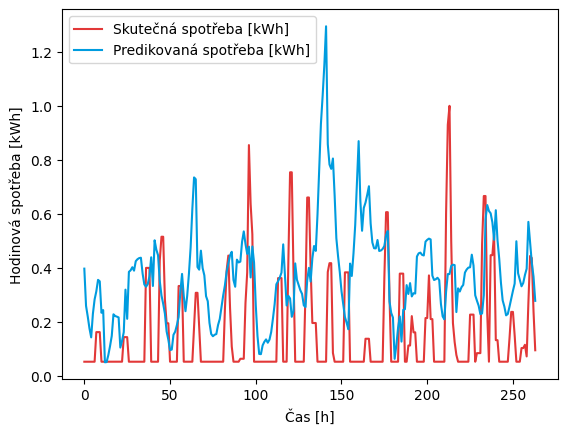

In [ ]:




datetime_start = datetime(2024, 3, 14, 0, 0, 0)

plt.figure()
best_r2 = 0
best_rmse = 20
start_index_best = None
end_index_best = None
window_size_best = None

# for cycle for increasing the window by 24 with nested for rolling this window through dataset to find best r2 value
for window_size in range(7*24, len(y_pred_inv_df), 24):
    for start_index in range(0, (len(y_pred)-window_size), 1):
        end_index = start_index + window_size
        y_plot = y_pred_inv_df.copy()
        y_plot = y_plot.reset_index(drop=True)[start_index:end_index]
        # y_plot = y_plot[:].reset_index(drop=True)
        # plt.plot(y_plot['truth'], label=f'Skutečná spotřeba [kWh]', alpha=1,color='#e23838' )
        # plt.plot(y_plot['longtime_mean'], label=f'Predikovaná spotřeba [kWh]', alpha=1, color='#009cdf')
        # set axis labels
        mape = np.mean(np.abs((y_pred_inv_df['truth'] - y_pred_inv_df['longtime_mean']) / y_pred_inv_df['truth'])) * 100

        # # plt.title(f'Prediction and real consumption of heat from boiler')
        # # plt.title(f'Predikovaná a skutečná hodinová spotřeba tepla z bojleru')
        # plt.xlabel('Time [h]')
        # plt.xlabel('Čas [h]')
        # plt.xticks(rotation=0)
        # plt.ylabel('Hourly comsumption [Wh]')
        # plt.ylabel('Hodinová spotřeba [Wh]')
        # plt.legend()

        # # set bigger font
        # plt.savefig(f'prediction_zuka.pdf', format='
        # ', dpi=500)

        # plt.show()

        # save fig as vector png

        # save as pdf
        # slope, intercept, r_value, p_value, std_err = stats.linregress(x=y_pred_inv_df['longtime_mean'],y=y_pred_inv_df['truth'])
        r2 = np.corrcoef(y_plot['truth'], y_plot['longtime_mean'])[0, 1] ** 2
        rmse = mean_squared_error(y_true=y_plot['truth'], y_pred=y_plot['longtime_mean'], squared=False)

        if (rmse < best_rmse):
            best_rmse = rmse
            start_index_best = start_index
            end_index_best = end_index
            window_size_best = window_size
            

        # testing_df = y_plot.copy()
        # # normalize from 0 to 1
        # testing_df['truth'] = (testing_df['truth'] - testing_df['truth'].min()) / (testing_df['truth'].max() - testing_df['truth'].min())
        # testing_df['longtime_mean'] = (testing_df['longtime_mean'] - testing_df['longtime_mean'].min()) / (testing_df['longtime_mean'].max() - testing_df['longtime_mean'].min())

        # mse = mean_squared_error(y_true=testing_df['truth'], y_pred=testing_df['longtime_mean'], squared=True)
        # rmse = mean_squared_error(y_true=testing_df['truth'], y_pred=testing_df['longtime_mean'], squared=False)
        # mse = mean_squared_error(y_true=y_plot['truth'], y_pred=y_plot['longtime_mean'], squared=True)
        # emse = mean_squared_error(y_true=y_plot['truth'], y_pred=y_plot['longtime_mean'], squared=False)
        # nrmse = rmse / (y_plot['truth'].max() - y_plot['truth'].min())
        # print('R2 = ',r2)
        # print('mse = ',mse)
        # print('rmse = ',rmse)
        # print('nrmse = ',nrmse)
        # #print integral of y_pred_curr - y_truth_curr
        # print('integral delta = ',np.trapz(y_plot['truth'] - y_plot['longtime_mean']))
        # print('integral_truth = ',np.trapz(y_plot['truth']))
        # print('integral_pred = ',np.trapz(y_plot['longtime_mean']))

        # # print percentual differece between integral of y_pred_curr - y_truth_curr and integral_truth
        # print('integral delta percentual = ',np.trapz(y_plot['longtime_mean'] - y_plot['truth'])/np.trapz(y_plot['truth']))
        # print('mape:', mape)

print(f'start_index_best: {start_index_best}')
print(f'end_index_best: {end_index_best}')
print(f'window_size_best: {window_size_best}')
print(f'best r2: {best_r2}')


y_plot = y_pred_inv_df.copy()
y_plot = y_plot.reset_index(drop=True)[start_index_best:end_index_best]
y_plot = y_plot[:].reset_index(drop=True)
plt.plot(y_plot['truth'], label=f'Skutečná spotřeba [kWh]', alpha=1,color='#e23838' )
plt.plot(y_plot['longtime_mean'], label=f'Predikovaná spotřeba [kWh]', alpha=1, color='#009cdf')
testing_df = y_plot.copy()
# normalize from 0 to 1
testing_df['truth'] = (testing_df['truth'] - testing_df['truth'].min()) / (testing_df['truth'].max() - testing_df['truth'].min())
testing_df['longtime_mean'] = (testing_df['longtime_mean'] - testing_df['longtime_mean'].min()) / (testing_df['longtime_mean'].max() - testing_df['longtime_mean'].min())

mape = np.mean(np.abs((y_pred_inv_df['truth'] - y_pred_inv_df['longtime_mean']) / y_pred_inv_df['truth'])) * 100
mse = mean_squared_error(y_true=testing_df['truth'], y_pred=testing_df['longtime_mean'], squared=True)
rmse = mean_squared_error(y_true=testing_df['truth'], y_pred=testing_df['longtime_mean'], squared=False)
mse = mean_squared_error(y_true=y_plot['truth'], y_pred=y_plot['longtime_mean'], squared=True)
emse = mean_squared_error(y_true=y_plot['truth'], y_pred=y_plot['longtime_mean'], squared=False)
nrmse = rmse / (y_plot['truth'].max() - y_plot['truth'].min())
print('R2 = ',best_r2)
print('R2 = ',r2)
print('mse = ',mse)
print('rmse = ',rmse)
print('nrmse = ',nrmse)
#print integral of y_pred_curr - y_truth_curr
print('integral delta = ',np.trapz(y_plot['truth'] - y_plot['longtime_mean']))
print('integral_truth = ',np.trapz(y_plot['truth']))
print('integral_pred = ',np.trapz(y_plot['longtime_mean']))

# print percentual differece between integral of y_pred_curr - y_truth_curr and integral_truth
print('integral delta percentual = ',np.trapz(y_plot['longtime_mean'] - y_plot['truth'])/np.trapz(y_plot['truth']))
print('mape:', mape)
# plt.title(f'Prediction and real consumption of heat from boiler')
# plt.title(f'Predikovaná a skutečná hodinová spotřeba tepla z bojleru')
plt.xlabel('Time [h]')
plt.xlabel('Čas [h]')
plt.xticks(rotation=0)
plt.ylabel('Hourly comsumption [Wh]')
plt.ylabel('Hodinová spotřeba [kWh]')
plt.legend()

plt.savefig(f'prediction_zuka.pdf', format='pdf', dpi=500)
plt.show()


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

ModuleNotFoundError: No module named 'statsmodels'

In [ ]:
data = y_plot['longtime_mean']
decompse = seasonal_decompose(data, model='additive', period=24)
decompse.plot()
data = y_plot['truth']
decompse = seasonal_decompose(data, model='additive', period=24)
decompse.plot()
